# QC on WaferGen PCR SmartChip


## Get Data

In [1]:
import pandas, os, glob
import logging
import matplotlib.pyplot as plt
import seaborn 
%matplotlib inline
FORMAT = "%(asctime)s:%(levelname)s:%(message)s"
logging.basicConfig(format=FORMAT)
LOG= logging.getLogger()
LOG.setLevel(logging.DEBUG)

class FilePaths():
    def __init__(self):
#         self.dire =  r'/home/b3053674/Documents/WaferGen/2D_TGFb'
        self.dire=r'C:\Users\Ciaran\Documents\Miscellaneous\WaferGenAnalysis'
        self.ncl = os.path.join(self.dire, 'GSS2242_NCGeneSet')
        self.ecm = os.path.join(self.dire, 'GSS2266_ECMGeneSet')
        self.ncl_raw_data_files = sorted(glob.glob(os.path.join(self.ncl, '*WellData*')  )  )
        self.ecm_raw_data_files = sorted(glob.glob(os.path.join(self.ecm, '*WellData*')  )  )
        self.QC = os.path.join(self.dire, 'QCResults')
        
        self._make_qc()
        
    def _make_qc(self):
        """
        
        """
        if os.path.isdir(self.QC)!=True:
            os.makedirs(self.QC)


F=FilePaths()

def parse_data(data1, data2, labels1, labels2):
    """
    Parse smart-chip PCR data
    
    args:
        data1: data from chip 1 (NCL or ECM)
    
        data2 Data from chip2 (NCL or ECM)
        
        labels1: labels for chips (NCL or ECM)
        
        labels2: Condition labels (Neonatal, IR and Adult)
    
    """

    ## construct python dict for data
    dct = {}
    for i in range(len(labels1)):
        dct[labels1[i]] = {}

    for i in range(len(labels1)):
        for j in range(len(labels2)):
            if labels1[i]=='Chip1NCL':
                dct[labels1[i]][labels2[j]] = pandas.read_csv(data1[j], sep='\t')
            elif labels1[i]=='Chip2ECM':
                dct[labels1[i]][labels2[j]] = pandas.read_csv(data2[j], sep='\t')

    ## remove unwanted columns
    columns = ['Assay', 'Sample','Ct']
    dct2 = {}
    for chip in dct:
        dct2[chip] = {}
        for treatment in dct[chip]:
            dct2[chip][treatment] = dct[chip][treatment][columns]
            
    ## parse data into one pandas dataframe

    df_dct = {}
    for chip in dct2:
        df_dct[chip] = pandas.concat(dct2[chip])
        
    return pandas.concat(df_dct)

    
ncl_raw_data = sorted(glob.glob(os.path.join(F.ncl, '*WellData*')  )  )
ecm_raw_data = sorted(glob.glob(os.path.join(F.ecm, '*WellData*')  )  )

labels1 = ['Chip1NCL', 'Chip2ECM']
labels2 = ['Neonatal', 'IR', 'Adult']
    
    
LOG.info('Parsing data from file into python ')
df = parse_data(F.ncl_raw_data_files, F.ecm_raw_data_files, labels1, labels2)

def format_data(df):
    """
    Make data look pretty
    """
    LOG.debug('DataFrame now looks like this:\n{}'.format(df.head()) )
    df=df.reset_index()
    df=df.drop('level_2', axis=1)
    df.columns = ['Chip', 'CellType', 'Gene', 'Sample', 'Ct']
    # df4=df3.set_index(['Chip','CellType','Gene','Sample'])
    df = df.dropna()
    return df

    
df = format_data(df)

2017-07-12 19:04:44,477:INFO:Parsing data from file into python 
2017-07-12 19:04:44,654:DEBUG:DataFrame now looks like this:
                   Assay     Sample        Ct
Chip1NCL Adult 0    ABL1  Tgfb_48_4  23.98787
               1    ACTB  Tgfb_48_4  21.11110
               2   CDC42  Tgfb_48_4  24.20522
               3  CDKN2A  Tgfb_48_4  28.10812
               4   NFKB2  Tgfb_48_4  28.18900



## Plot some graphs that serve as QC

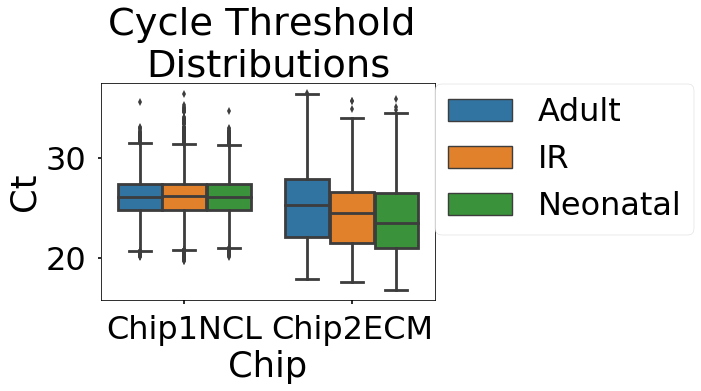

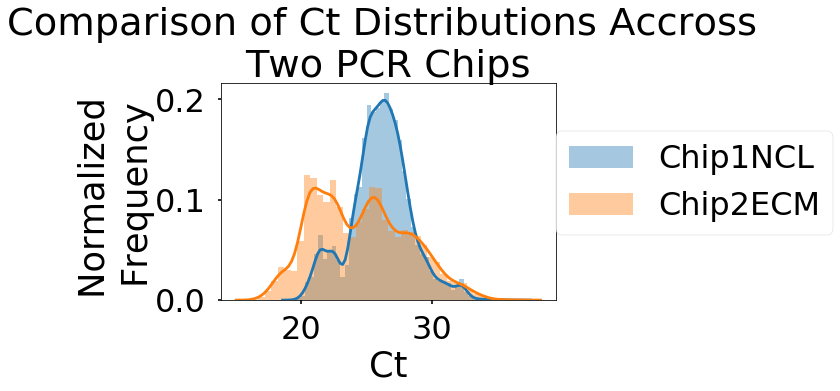

In [126]:
seaborn.set_context(context='poster', font_scale=2)

SAVE = True

PLOT_CYCLE_THRESHOLD_DISTRIBUTIONS = True
PLOT_DENSITY = True




if PLOT_CYCLE_THRESHOLD_DISTRIBUTIONS:
    
# seaborn.boxplot(data=df3, x='Chip', y='Ct', hue='Chip')
    plt.figure()
    seaborn.boxplot(data=df, x='Chip', y='Ct', hue='CellType')
    plt.title('Cycle Threshold \nDistributions')
    plt.legend(loc=(1,0.3))
    if SAVE:
        plt.savefig(os.path.join(F.QC, 'RawCtDistributionsPerChipPerCellType.png'), bbox_inches='tight', dpi=300)
        
if PLOT_DENSITY:
    plt.figure()
    for label, d in df.groupby(by='Chip'):
        seaborn.distplot(d['Ct'], label=label)
        plt.legend(loc=(1,0.3))
        plt.title('Comparison of Ct Distributions Accross \nTwo PCR Chips')
        plt.ylabel('Normalized \nFrequency')
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'DensityPlotCtDistributions.png'), bbox_inches='tight', dpi=300)


# PCA

2017-07-12 21:29:20,720:DEBUG:Formatting Data for PCA
2017-07-12 21:29:20,862:DEBUG:df_indexed now looks like this:
                                            Ct
Chip     CellType Gene   Repeat Time          
Chip1NCL Adult    ABL1   4      48    23.98787
                  ACTB   4      48    21.11110
                  CDC42  4      48    24.20522
                  CDKN2A 4      48    28.10812
                  NFKB2  4      48    28.18900
2017-07-12 21:29:20,873:DEBUG:Performing imputation for missing values


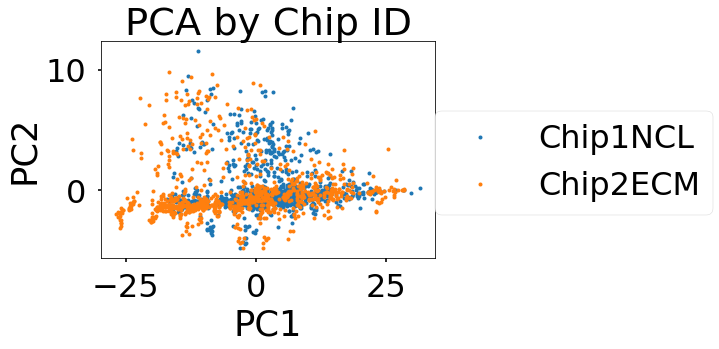

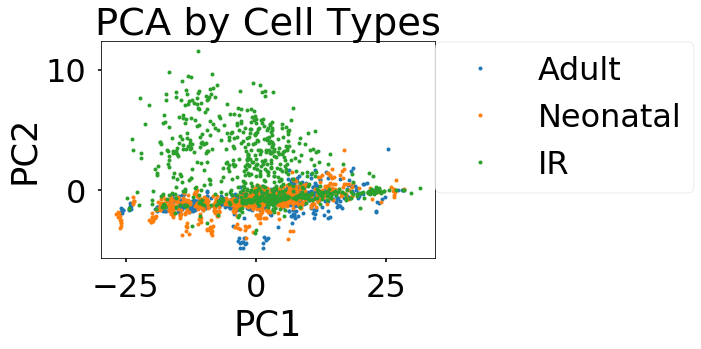

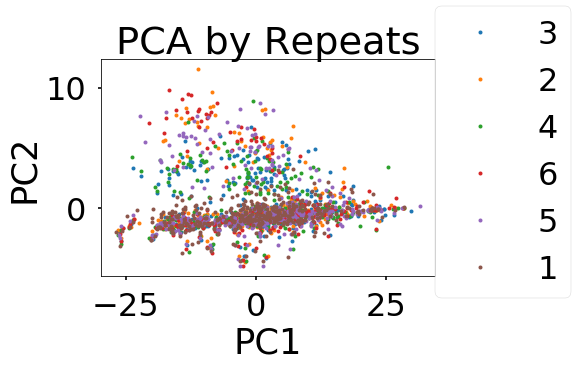

In [120]:
from sklearn.decomposition import PCA
from sklearn import preprocessing


PLOT_EXPLAINED_VARIANCE_RATIO = False
SAVE=False
PLOT_PCA = True
# df_indexed = df.set_index(['Chip', 'CellType', 'Gene', 'Sample'])

def plot_pca(df, hue, PLOT_EXPLAINED_VARIANCE_RATIO=True, SAVE=False, PLOT_PCA=True,ms=2):
    """
    """
    seaborn.set_context(context='poster', font_scale=2)
    ## format split samples column by '_' to get more detailed index
    LOG.debug('Formatting Data for PCA')
    sample_ids = list(df['Sample'])
    sample_ids = [i.split('_') for i in sample_ids]
    treat, time, repeat =  zip(*sample_ids)  
    df_indexed = df.copy()
    df_indexed['Time'] = time
    df_indexed['Repeat'] = repeat

    df_indexed  = df_indexed.set_index(['Chip','CellType','Gene','Repeat','Time'])
    df_indexed = df_indexed.drop('Sample', axis=1)
    LOG.debug('df_indexed now looks like this:\n{}'.format(df_indexed.head()))

    df_indexed =df_indexed.unstack()
    
    df_indexed.columns = df_indexed.columns.droplevel(0)
    
    
    
    seaborn.color_palette("hls", 24)


    ##imputation with median prior to feeding into PCA
    LOG.debug('Performing imputation for missing values')
    imp =preprocessing.Imputer(strategy='median', axis=1)
    imp.fit(df_indexed)
    df_imputed = (imp.transform(df_indexed))
    df_imputed = pandas.DataFrame(df_imputed, columns=df_indexed.columns, index =df_indexed.index ) 
    df_imputed = df_imputed[sorted(df_imputed.keys())]
    
    if PLOT_EXPLAINED_VARIANCE_RATIO :
        pca = PCA(n_components=10)
        pca = pca.fit(df_imputed)
        plt.figure()
        plt.title('Explained Variance Ratio for First \n 10 Principle Components')
        var_ratio = pca.explained_variance_ratio_
        plt.plot(range(len(var_ratio)), var_ratio)
        plt.ylabel('Explained Variance\n Ratio')
        plt.xlabel('Principle Component')
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'ExplainedVarianceRatioPlot.jpeg'), bbox_inches='tight', dpi=300)
        

    if PLOT_PCA:
        
        BY_CHIP = True
        BY_CELL_TYPE = True
        BY_REPEAT = True

        pca = PCA(n_components=2)
        pca = pca.fit(df_imputed)
        pca_df = pandas.DataFrame(pca.transform(df_imputed), index=df_imputed.index) 

        if BY_CHIP:
            hue = list(set(pca_df.index.get_level_values(0)))
            plt.figure()
            for i in range(len(hue)):# set(list(pca_df.index.get_level_values(0))):
                plt.title('PCA by Chip ID')
                plt.plot(pca_df.loc[hue[i]][0], pca_df.loc[hue[i]][1],'o',label=hue[i],markersize=ms)
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.legend(loc=(1, 0.2))
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'PCAByChipID.eps'), bbox_inches='tight', dpi=300)

        if BY_CELL_TYPE:
            hue = list(set(pca_df.index.get_level_values(1)))
            pca_df_cell_type = pca_df.reorder_levels([1,0,2,3])
#             print(pca_df_cell_type)
            plt.figure()
            for i in range(len(hue)):
                plt.title('PCA by Cell Types')
                plt.plot(pca_df_cell_type.loc[hue[i]][0], pca_df_cell_type.loc[hue[i]][1],
                        'o', label=hue[i],markersize=ms)
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.legend(loc=(1,0.3))
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'PCAByCellType.eps'), bbox_inches='tight', dpi=300)


        if BY_REPEAT:
            hue = list(set(pca_df.index.get_level_values(3)))
            pca_df_repeat = pca_df.reorder_levels([3,1,2,0])
            plt.figure()
            for i in range(len(hue)):
                plt.title('PCA by Repeats')
                plt.plot(pca_df_repeat.loc[hue[i]][0], pca_df_repeat.loc[hue[i]][1],
                        'o', label=hue[i], markersize=ms)
                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.legend(loc=(1,-0.1))
        if SAVE:
            plt.savefig(os.path.join(F.QC, 'PCAByRepeat.eps'), bbox_inches='tight', dpi=300)


        # pca.fit(df_indexed)/

plot_pca(df, 0, ms=4, SAVE=True)